# Predição dos deputados Federais eleitos ou não eleitos


In [776]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import seaborn as sns


import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import preprocessing
from sklearn import metrics

%config InlineBackend.figure_format = 'png' 
%matplotlib inline

sns.set(style="darkgrid")

In [777]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

Abaixo é possível análise uma pequena partes dos dados originais.

In [778]:
train.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,situacao
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.67,0.0,...,14,14,16583.60,1184.54,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,nao_eleito
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.85,6625.0,...,24,23,20325.99,846.92,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,nao_eleito
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,158120.80,9301.22,2250.0,...,123,108,146011.70,1187.09,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,eleito
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.19,0.0,...,8,8,3001.12,375.14,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,nao_eleito
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,119820.00,2496.25,0.0,...,133,120,116416.64,875.31,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,eleito


Vamos agora analisar a distribuição das classes eleito e nçai eleito nos dados de treino

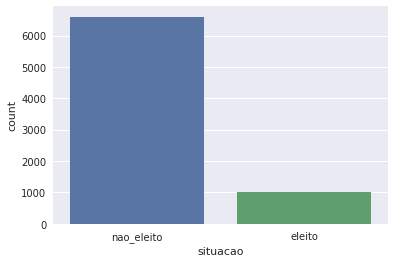

In [779]:
sns.countplot(x="situacao", data=train)

Como podemos verificar na distribuição existem poucas examplares no dados com valor eleito (cerca de 1000) enquanto examplares nos dados com valor não eleito são representados por mais de 6000, o que demostra um desbalanceamento de classes. Este resultado pode resultar e uma alta acurácia de forma erroneamente (Overfitting). 

Nesse contexto, aplicamos a técnica de Random under-sampling para balancear a duas classes. Essa técnica consiste remover amostrar da classe majoritária, ficando assim ambas com mesmo número de aparições e balanceadas. 

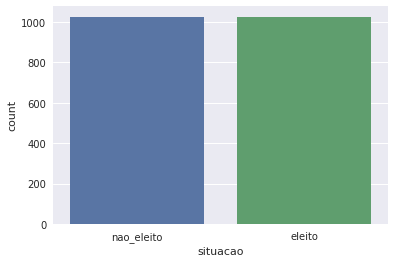

In [780]:
count_class_1, count_class_0 = train.situacao.value_counts()
df_class_0 = train[train['situacao'] == "eleito"]
df_class_1 = train[train['situacao'] == "nao_eleito"]

df_class_1_under = df_class_1.sample(count_class_0, replace=True)
train = pd.concat([df_class_1_under, df_class_0], axis=0)

sns.countplot(x="situacao", data=train)

### Tratamento nos dados

Para considerar somente features relevantes, foram desconsideradas as seguintes variáveis:

ano - Com os dados de treino e teste utilizados são somente de único ano, esta informação logo pode ser desconsiderada
sequencial_candidato é apenas um identificador de cada candidato que não será útil para predição
Nome - O nome do candidato
Cargo - considerando que todos os parlamentares são Deputados Federais essa infomação não é útil.


In [781]:
train = train.drop(["ano", "sequencial_candidato", "nome", "cargo"], axis=1)
test = train.drop(["ano", "sequencial_candidato", "nome", "cargo"], axis=1)

Como medida para reduzir o envisamento nos dados, iremos aplicar log em todas as variáveis numéricas que serão utilizadas na predição. Além disso, iremos remover valores NA dos presentes nos dados.

A função abaixo remove os valores NA das variáveis numéricas e substitui pela média dos valores ao qual a coluna pertence.

In [782]:
def remove_NA(data):
    #remove NA das variáveis e substitui pela média
    return data.fillna(data.mean())

Para aplicar o log nas variáveis, a fim de diminuir seu enviesamento a função abaixo foi criada.

In [783]:
def set_log_numeric_variables(data):
    numeric_feats = data.dtypes[data.dtypes != "object"].index
    
    #coloca valores das variáveis numéricas em escala de log
    data[numeric_feats] = np.log1p(data[numeric_feats])

    return data

Varios dos algoritmos de Aprendizado de máquina para classificação necessitam de dados numéricos. Assim, vamos converter nossas variáveis categóricas em valores numéricos.

In [784]:
def convert_categorical_variable_in_numeric(data):
    data['uf'] = le.fit_transform(data['uf'])
    data['partido'] = le.fit_transform(data['partido'])
    data['sexo'] = le.fit_transform(data['sexo'])
    data['grau'] = le.fit_transform(data['grau'])
    data['estado_civil'] = le.fit_transform(data['estado_civil'])
    data['ocupacao'] = le.fit_transform(data['ocupacao'])
    data['situacao'] = le.fit_transform(data['situacao'])
    return data

Para normalizar as variáveis presentes nos dados comm valores entre 0 a 1, a função de normalização abaixo foi criada.

In [785]:
def data_normalization(data):
    #log transform skewed numeric features:
    numeric_feats = data.dtypes[data.dtypes != "object"].index
    
    #identifica as variáveis categóricas
    cat_feats = data.dtypes[data.dtypes == "object"].index

    min_max = preprocessing.MinMaxScaler()
    data_normalized = min_max.fit_transform(data[numeric_feats])
    
    data_normalized = pd.DataFrame(data_normalized, columns=data[numeric_feats].columns)
    
    data = pd.concat([data_normalized, data[cat_feats].reset_index()], axis = 1, sort = False)
    
    return data

Aqui vamos aplicar todas as funções descritas anteriormente.

In [786]:
def data_proccess(data):
    
     #1. substitui NA pela média da coluna
    data = remove_NA(data)
    
    #2. aplica log nas variáveis numéricas
    data = set_log_numeric_variables(data)
    
    #3. normaliza variáveis
    data = data_normalization(data)
    
    #4.Converte variáveis categóricas
    data = convert_categorical_variable_in_numeric(data)
    
    return data

### Modelagem

In [787]:
#tratamendo dos dados de treino
train = data_proccess(train)
train = train.drop("index", axis=1)

features = train.drop('situacao', axis=1)
label = train.situacao

#dados teste
test = data_proccess(train)
test = train.drop("index", axis=1)

features_test = train.drop('situacao', axis=1)
label_test = train.situacao

train.head()


,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,uf,partido,sexo,grau,estado_civil,ocupacao,situacao
0,0.335878,0.339668,0.681735,0.570318,0.000000,0.746243,0.381190,0.614710,0.000000,0.349031,0.328714,0.651852,0.581066,20,9,0,5,0,62,1
1,0.229381,0.234778,0.616068,0.565961,0.595371,0.588089,0.496864,0.535375,0.512723,0.291982,0.292915,0.621452,0.586850,22,18,1,5,2,74,1
2,0.381547,0.378849,0.638057,0.482244,0.000000,0.712085,0.000000,0.534258,0.000000,0.301387,0.298020,0.631957,0.593757,5,23,1,5,3,1,1
3,0.432140,0.288811,0.665544,0.480895,0.630670,0.606554,0.000000,0.456744,0.671392,0.417762,0.287584,0.628192,0.488099,25,10,1,5,0,1,1
4,0.288151,0.288811,0.546980,0.434849,0.000000,0.524482,0.487572,0.535375,0.000000,0.410848,0.411845,0.551218,0.383495,25,30,0,5,1,68,1


In [788]:

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score

def cross_validation(model, cv=10):
    score = cross_val_score(model, features, label, scoring="accuracy", cv = cv)
    return(score)

### KNN

In [789]:
from sklearn.neighbors import KNeighborsClassifier

lista_range = list(range(1,50))
neighbors = list(filter(lambda x: x % 2 != 0, lista_range))

cv_scores = [cross_validation(KNeighborsClassifier(n_neighbors = k_value), cv=10).mean() 
            for k_value in neighbors]

MSE = [1 - x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print ("O melhor valor para neighbors é: ", optimal_k)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


O melhor valor para neighbors é:  17


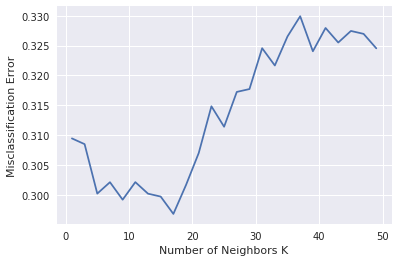

In [790]:
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [791]:
# Treinando modelo 
model = KNeighborsClassifier(n_neighbors=optimal_k)
model.fit(features, label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=2,
           weights='uniform')

### Árvore de decisão (Decision Tree)

In [792]:
from sklearn.tree import DecisionTreeClassifier


lista_range = list(range(1,10))
depths = list(filter(lambda x: x % 2 != 0, lista_range))

cv_scores = [cross_validation(DecisionTreeClassifier(max_depth = depth_value), cv=10).mean() 
            for depth_value in depths]

MSE = [1 - x for x in cv_scores]
optimal_depth = depths[MSE.index(min(MSE))]
print ("O melhor valor para max depth é: ", optimal_depth)

O melhor valor para max depth é:  1


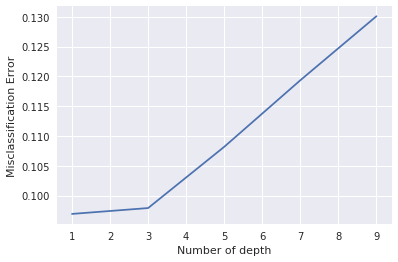

In [793]:
plt.plot(depths, MSE)
plt.xlabel('Number of depth')
plt.ylabel('Misclassification Error')
plt.show()

In [794]:
#treinando o modelo
classifier = DecisionTreeClassifier(max_depth=optimal_depth)  
classifier.fit(features, label)  

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Adaboost

In [795]:
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier


lista_range = list(range(1,10))
depths = list(filter(lambda x: x % 2 != 0, lista_range))

cv_scores = [cross_validation(DecisionTreeClassifier(max_depth = depth_value), cv=10).mean() 
            for depth_value in depths]

MSE = [1 - x for x in cv_scores]
optimal_depth = depths[MSE.index(min(MSE))]
print ("O melhor valor para max depth é: ", optimal_depth)

O melhor valor para max depth é:  1


In [796]:
#treinando o modelo
abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)
model = abc.fit(X_train, y_train)

NameError: name 'X_train' is not defined